In [10]:
import os
import pathlib
import datetime as dt
from copy import deepcopy

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import Compose, ToTensor, Normalize
import torchvision.transforms.functional as TVF

from torchsummary import summary

from ViT_v1 import ViT
from train_test_loop import train_loop, test_loop

In [2]:
# 0. Config
ROOT_PATH = "./DATA/CIFAR10"
img_size = (3, 32, 32)  # 이미지 크기
patch_size = 4  # 패치 크기
dim_model = 64  # 임베딩 벡터 차원
num_heads = 8  # MHA의 헤드 개수
n_enc_block = 6  # 인코더 블록 개수
batch_size = 128
MODEL_PATH = pathlib.Path("./models")

In [3]:
os.makedirs(MODEL_PATH, exist_ok=True)

start = dt.datetime.now().strftime("%Y%m%d_%H%M")

In [4]:
# 1. DATASETS & DATALOADERS
# 1.1. Loading a Dataset
train_dataset = datasets.CIFAR10(root=ROOT_PATH,
                                 train=True,
                                 download=True,
                                 transform=Compose([ToTensor(), Normalize((0, 0, 0), (1, 1, 1))])
                                 )
test_dataset = datasets.CIFAR10(root=ROOT_PATH,
                                train=False,
                                download=True,
                                transform=Compose([ToTensor(), Normalize((0, 0, 0), (1, 1, 1))])
                                )
n_class = len(train_dataset.classes)  # 클래스 개수

100%|██████████| 170498071/170498071 [00:01<00:00, 103182899.00it/s]


Extracting ./DATA/CIFAR10/cifar-10-python.tar.gz to ./DATA/CIFAR10
Files already downloaded and verified


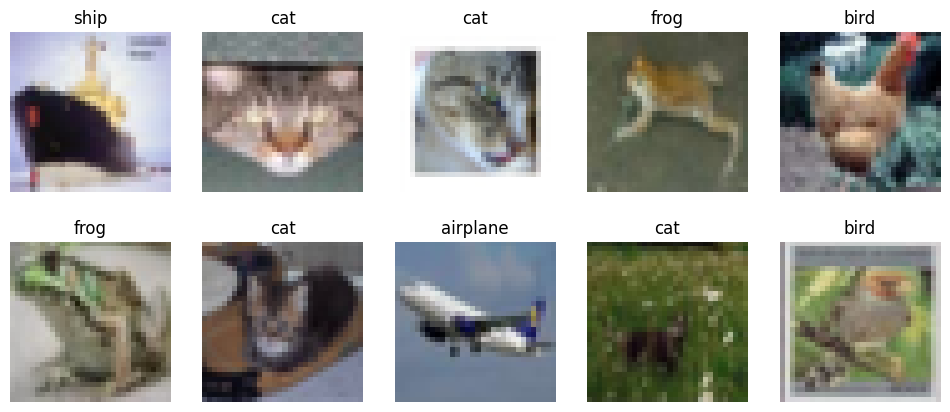

In [67]:
# [Optional] Iterating and Visualizing the Dataset
labels_map = {v: k for k, v in train_dataset.class_to_idx.items()}
figure = plt.figure(figsize=(12, 5))
ncols, nrows = 5, 2
for i in range(1, ncols * nrows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    img = np.asarray(TVF.to_pil_image(img.detach()))

    figure.add_subplot(nrows, ncols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze())
plt.show()

In [6]:
# 1.2. Preparing your data for training with DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [7]:
# 2. Build the Neural Network
# 2.1. Get Device for Training
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [8]:
# 2.2. Define the Class
model = ViT(n_class=n_class, in_channels=img_size[0], img_size=img_size[1],
            patch_size=patch_size, dim_model=dim_model, num_heads=num_heads, n_enc_block=n_enc_block,
            mha_dropout=0.1, enc_dropout=0.1, ff_dropout=0.1, clsff_dropout=0.1,
            device=device
            )

In [11]:
# 2.3. Check the Number of Parameters
summary(model, (3, 32, 32), device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Patches-1               [-1, 64, 48]               0
            Linear-2               [-1, 64, 64]           3,136
         Embedding-3               [-1, 64, 64]           4,096
    PatchEmbedding-4               [-1, 64, 64]               0
         LayerNorm-5               [-1, 64, 64]             128
            Linear-6               [-1, 64, 64]           4,160
            Linear-7               [-1, 64, 64]           4,160
            Linear-8               [-1, 64, 64]           4,160
           Dropout-9            [-1, 8, 64, 64]               0
           Linear-10               [-1, 64, 64]           4,160
MultiHeadAttention-11               [-1, 64, 64]               0
          Dropout-12               [-1, 64, 64]               0
      ResidualAdd-13               [-1, 64, 64]               0
        LayerNorm-14               [-1

In [12]:
# 3. Optimizing Model Parameters
# 3.1. Hyperparameters
learning_rate = 1e-3
epochs = 50

In [14]:
# 3.2. Optimization Loop
loss_fn = nn.CrossEntropyLoss(reduction="sum")
optimizer = optim.SGD(model.parameters(), lr=learning_rate)  # Adam은 왜 안 될까?

loss_hist = {"train": [], "val": []}
metric_hist = {"train": [], "val": []}
best_metric, best_epoch = 0, 0
print(f"Start Time: {start}\n----------------------------------------------------------------")
for epoch in range(epochs):
    epoch_start = dt.datetime.now()
    print(f"Epoch {epoch+1} / {epochs}")

    # Train
    train_loss, train_metric = train_loop(train_dataloader, model, loss_fn, optimizer, device=device, print_batch=False)
    loss_hist["train"].append(train_loss)
    metric_hist["train"].append(train_metric)
    print(f"Train Error: \n Accuracy: {(100 * train_metric):>0.1f}%, Avg loss: {train_loss:>7f}")

    # Validation
    test_loss, test_metric = test_loop(test_dataloader, model, loss_fn, device=device)
    loss_hist["val"].append(test_loss)
    metric_hist["val"].append(test_metric)
    print(f"Valid Error: \n Accuracy: {(100 * test_metric):>0.1f}%, Avg loss: {test_loss:>7f}")

    # Best
    if test_metric > best_metric:
        best_model = deepcopy(model)
        best_metric = deepcopy(test_metric)
        best_epoch = deepcopy(epoch)
        torch.save(best_model.state_dict(), MODEL_PATH / f"{start}_best_weights.pth")
        torch.save(best_model, MODEL_PATH / f"{start}_best_model.pth")
    epoch_end = dt.datetime.now()
    print(f"Best Accuracy: {(100*best_metric):>0.1f}% at Epoch {best_epoch + 1}, Epoch Lead Time: {(epoch_end-epoch_start).seconds/60:>0.1f} minutes."
          f"\n----------------------------------------------------------------")

print("Done!")
print(f"Start Time: {start} / End Time: {dt.datetime.now().strftime('%Y%m%d_%H%M')}"
      f"\n----------------------------------------------------------------")


Start Time: 20230811_0933
----------------------------------------------------------------
Epoch 1 / 50
Train Error: 
 Accuracy: 15.6%, Avg loss: 2.276205
Valid Error: 
 Accuracy: 21.9%, Avg loss: 2.224304
Best Accuracy: 21.9% at Epoch 1, Epoch Lead Time: 0.5 minutes.
----------------------------------------------------------------
Epoch 2 / 50
Train Error: 
 Accuracy: 26.9%, Avg loss: 2.178908
Valid Error: 
 Accuracy: 32.9%, Avg loss: 2.125727
Best Accuracy: 32.9% at Epoch 2, Epoch Lead Time: 0.5 minutes.
----------------------------------------------------------------
Epoch 3 / 50
Train Error: 
 Accuracy: 33.3%, Avg loss: 2.120326
Valid Error: 
 Accuracy: 36.4%, Avg loss: 2.090723
Best Accuracy: 36.4% at Epoch 3, Epoch Lead Time: 0.5 minutes.
----------------------------------------------------------------
Epoch 4 / 50
Train Error: 
 Accuracy: 36.8%, Avg loss: 2.086249
Valid Error: 
 Accuracy: 40.1%, Avg loss: 2.057993
Best Accuracy: 40.1% at Epoch 4, Epoch Lead Time: 0.5 minutes.
--

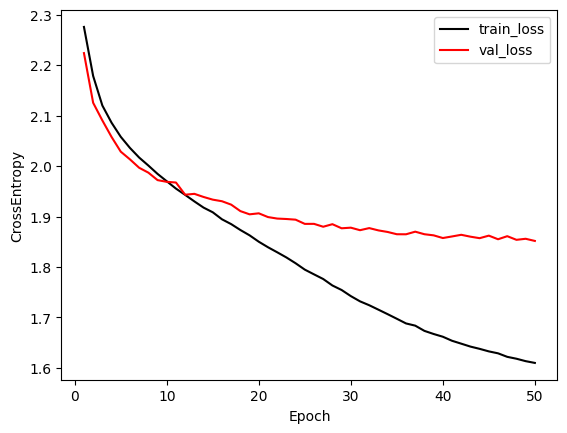

In [26]:
plt.plot(np.arange(epochs)+1, loss_hist["train"], c="k", label="train_loss")
plt.plot(np.arange(epochs)+1, loss_hist["val"], c="r", label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("CrossEntropy")
plt.legend()

plt.show()

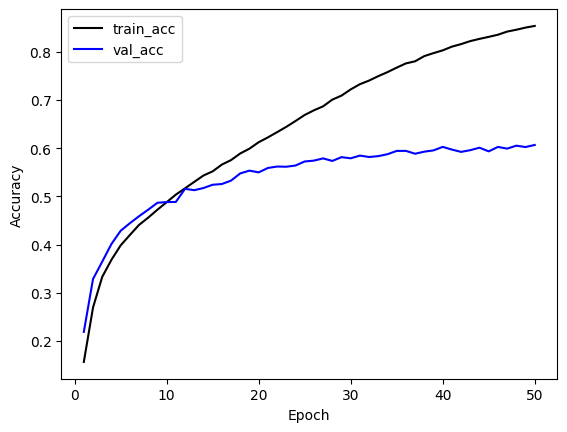

In [28]:
plt.plot(np.arange(epochs)+1, metric_hist["train"], c="k", label="train_acc")
plt.plot(np.arange(epochs)+1, metric_hist["val"], c="b", label="val_acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

In [64]:
best_model.eval()
with torch.no_grad():
    imgs, labels = next(iter(test_dataloader))
    preds = best_model(imgs).argmax(1).to("cpu")
    imgs = np.asarray([TVF.to_pil_image(img.detach()) for img in imgs])
    labels = labels.numpy()
    preds = preds.numpy()

<ipython-input-64-985ad0a5ceea>:5: FutureWarning: The input object of type 'Image' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Image', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  imgs = np.asarray([TVF.to_pil_image(img.detach()) for img in imgs])
<ipython-input-64-985ad0a5ceea>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  imgs = np.asarray([TVF.to_pil_image(img.detach()) for img in imgs])


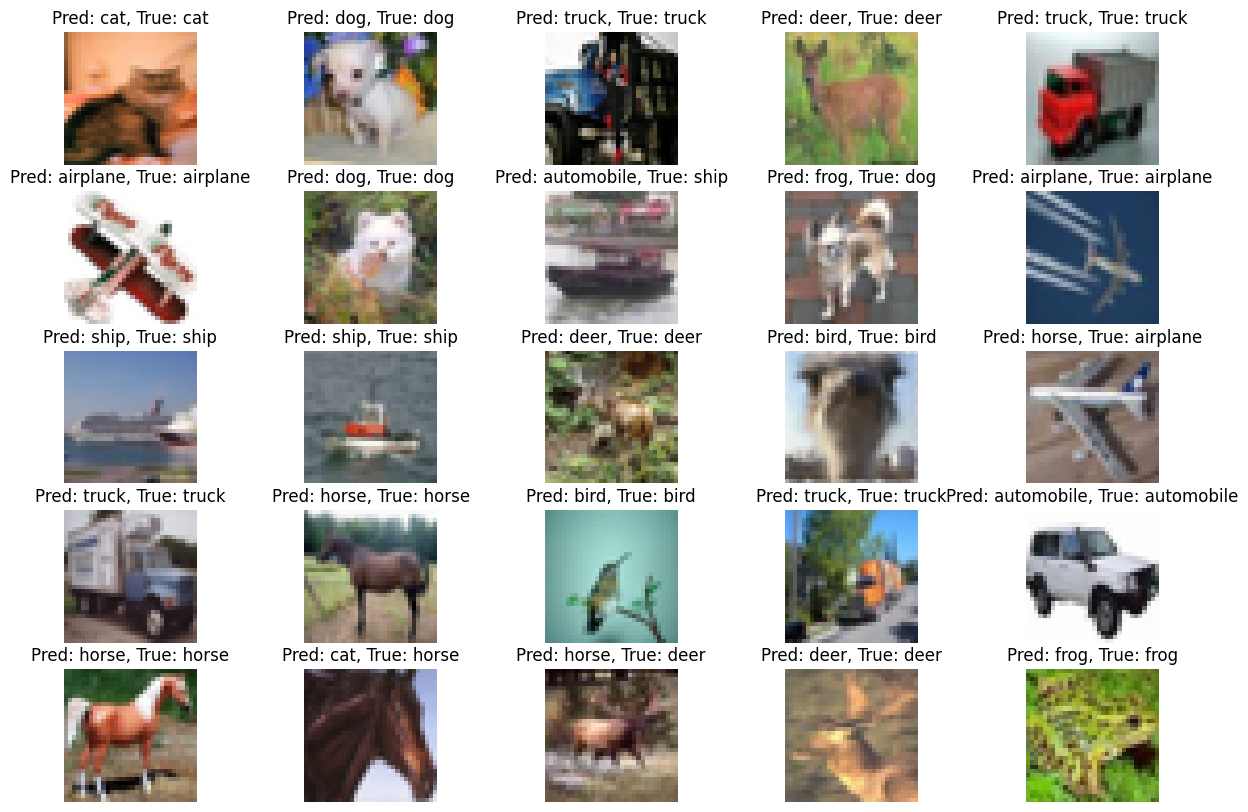

In [73]:
# [Optional] Iterating and Visualizing the Dataset
labels_map = {v: k for k, v in train_dataset.class_to_idx.items()}
figure = plt.figure(figsize=(15, 10))
ncols, nrows = 5, 5
for i in range(1, ncols * nrows + 1):
    figure.add_subplot(nrows, ncols, i)
    plt.title(f"Pred: {labels_map[preds[i]]}, True: {labels_map[labels[i]]}")
    plt.axis("off")
    plt.imshow(imgs[i])
plt.show()